In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from eggman.grid import luminosity, log_surface_gravity, calculate_eep, metallicity
from eggman.grid.defaults import MASS, YINI, ZINI, AGE, TEFF, RAD, DNUF, AMLT

import tensorflow as tf

print(f"Using TensorFlow {tf.__version__}")

DIR = "/mnt/data-storage/stellar-emulator/train"
FILENAME = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"

RSTATE = 0
EEP = "EEP"
PHASE = "phase"
LUM = "L"
GRAV = "g"
LOG = "log"
SEP = "_"

print(f"Loading grid data from '{FILENAME}'.")
tracks = pd.read_hdf(FILENAME, "tracks")
stars = pd.read_hdf(FILENAME, "stars")
data = tracks.join(stars).dropna().reset_index()
data.head()

2024-01-31 14:27:44.118095: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow 2.14.0
Loading grid data from '/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5'.


,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,Teff,center_h1,log_LHe,log_Lnuc,Dnu_freq_o,eps_o,delta_Pg
0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,0.893151,6382.509287,0.718192,-45.291905,0.078416,148.565794,1.129515,0.0
1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,0.891027,6377.312552,0.718122,-45.308912,0.077135,149.148739,1.131800,0.0
2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,0.890320,6373.785487,0.718037,-45.328570,0.075916,149.362908,1.132830,0.0
3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,0.893682,6371.412400,0.717474,-45.392646,0.075178,148.552167,1.130613,0.0
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,6371.453759,0.717253,-45.402736,0.075810,148.331713,1.129892,0.0


In [2]:
data["kron"] = data["star_age"] * data["star_mass"]**3.2
data["log_kron"] = np.log10(data["kron"])
data["M_H"] = metallicity(data)

In [3]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
from isochrones.interp import DFInterpolator

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [4]:
print("Preprocessing data.")
# Create log10 quantities
for key in [ZINI, AGE, TEFF, RAD, DNUF, MASS]:
    data[SEP.join([LOG, key])] = np.log10(data[key])

data[SEP.join([LOG, GRAV])] = log_surface_gravity(data)
data[SEP.join([LOG, LUM])] = np.log10(luminosity(data))

# Drop bad tracks
with open("../notebook/central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

data = data.drop(index=data[data.track.isin(bad)].index)

print("Calculating EEP.")
# Add EEP and drop pre-MS and post log_g cutoff
keys = [SEP.join([LOG, key]) for key in [TEFF, LUM]]
primary, secondary = calculate_eep(data, keys, alpha=0.5, boundaries=["zams", "end"])
data[PHASE] = primary
data[EEP] = secondary

data = data.drop(index=data[data.phase == -1].index)

Preprocessing data.
Calculating EEP.


In [5]:
BANDS = ["G", "BP", "RP"]

bc_grid = MISTBolometricCorrectionGrid(BANDS)
bc_grid.df.head()

G        BP        RP
Teff   logg [Fe/H] Av                                
2500.0 -4.0 -4.0   0.00 -2.181987 -4.652549 -0.881256
                   0.05 -2.211638 -4.697705 -0.909058
                   0.10 -2.241241 -4.742843 -0.936830
                   0.15 -2.270798 -4.787964 -0.964572
                   0.20 -2.300307 -4.833067 -0.992286

In [6]:
bc_interpolator = DFInterpolator(bc_grid.df.xs(0.00, level="Av"))

In [7]:
data[["Teff", "log_g", "M_H"]]

,Teff,log_g,M_H
4,6371.453759,4.500174,-0.852135
5,6371.395675,4.499387,-0.852135
6,6371.047385,4.497885,-0.852135
7,6370.652426,4.496376,-0.852135
8,6370.549143,4.494823,-0.852135
...,...,...,...
6587233,4192.969247,2.277606,0.487831
6587234,4176.349466,2.244528,0.487831
6587235,4170.127283,2.232024,0.487831
6587236,4164.145786,2.219796,0.487831


In [8]:
bcs = bc_interpolator(data[["Teff", "log_g", "M_H"]].to_numpy().T)

In [9]:
bol_mag_sun = 4.75
data["bol_mag"] = bol_mag_sun - 2.5 * data.log_L

In [10]:
for i, band in enumerate(BANDS):
    data[f"abs_{band}"] = data["bol_mag"] - bcs[:, i]

In [11]:
bp_rp = bcs[:, 2] - bcs[:, 1]

In [12]:
np.allclose(data.abs_BP - data.abs_RP, bp_rp)

True

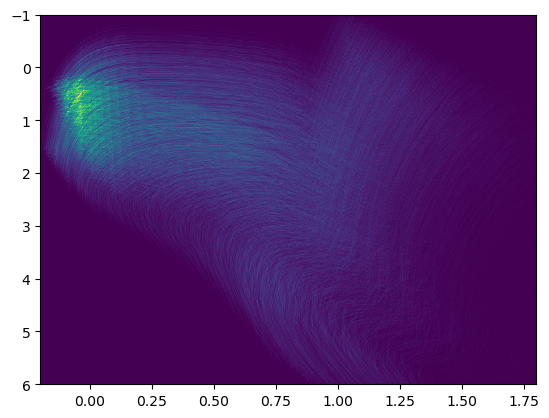

In [23]:
fig, ax = plt.subplots()

ax.hist2d(bp_rp, data["abs_G"], bins=500, range=[[-0.2, 1.8], [-1.0, 6.0]])
ax.invert_yaxis()

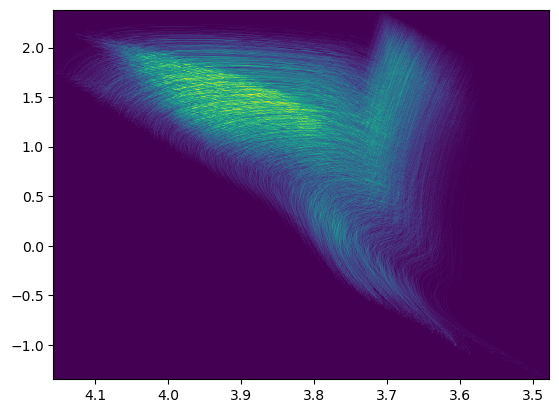

In [15]:
fig, ax = plt.subplots()

ax.hist2d(data["log_Teff"], data["log_L"], bins=500)
ax.invert_xaxis()

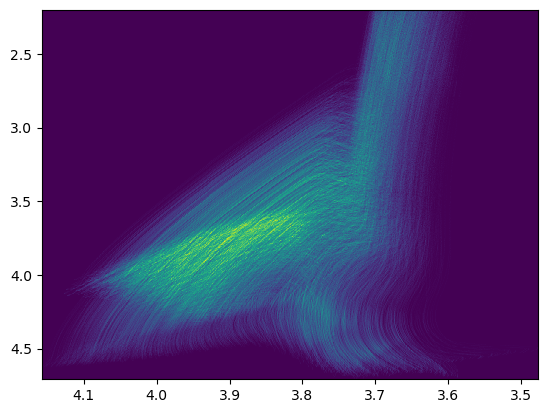

In [16]:
fig, ax = plt.subplots()

ax.hist2d(data["log_Teff"], data["log_g"], bins=500)
ax.invert_xaxis()
ax.invert_yaxis()

In [17]:
data

,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,...,log_g,log_L,delta_X,f_nuc,phase,EEP,bol_mag,abs_G,abs_BP,abs_RP
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,...,4.500174,0.074879,0.001608,1.002145,0,0.000000,4.562802,4.547648,4.770715,4.160442
5,7000,6,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.548000e+07,0.895385,...,4.499387,0.075651,0.001875,1.001741,0,0.000427,4.560872,4.545704,4.768774,4.158500
6,7000,7,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,4.309136e+07,0.896934,...,4.497885,0.077058,0.002592,1.001313,0,0.001206,4.557356,4.542152,4.765255,4.154919
7,7000,8,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,5.405171e+07,0.898494,...,4.496376,0.078459,0.003644,1.000889,0,0.001982,4.553852,4.538610,4.761750,4.151341
8,7000,9,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,6.983463e+07,0.900101,...,4.494823,0.079984,0.005195,1.000489,0,0.002826,4.550040,4.534769,4.757914,4.147505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587233,4999,480,0.99087,0.316689,0.036025,1.923737,0.0,0.006041,1.446116e+10,11.974001,...,2.277606,1.601259,0.647286,0.994609,0,0.968109,0.746853,1.078004,1.810856,0.266392
6587234,4999,481,0.99087,0.316689,0.036025,1.923737,0.0,0.006041,1.446395e+10,12.438793,...,2.244528,1.627438,0.647286,0.994784,0,0.980955,0.681406,1.024731,1.765951,0.207899
6587235,4999,482,0.99087,0.316689,0.036025,1.923737,0.0,0.006041,1.446496e+10,12.619153,...,2.232024,1.637351,0.647286,0.994722,0,0.985820,0.656622,1.004483,1.748819,0.185706
6587236,4999,483,0.99087,0.316689,0.036025,1.923737,0.0,0.006041,1.446593e+10,12.798060,...,2.219796,1.647086,0.647286,0.994695,0,0.990596,0.632286,0.984493,1.731817,0.163854


In [18]:
print("Preparing train and test dataset.")
train = data.sample(frac=0.8, random_state=RSTATE)
test = data.drop(index=train.index)

Preparing train and test dataset.


In [20]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/dataset.h5"
train.to_hdf(filename, "train")
test.to_hdf(filename, "test")